In [79]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV ,learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)  # 全ての列を表示
pd.set_option('display.width', None)        # 行の幅の制限を解除


In [80]:
def load_data(): # データの読み込み
    print("データを読み込んでいます...")
    teams = pd.read_csv('csv/1_1team.csv')
    grounds = pd.read_csv('csv/1_2ground.csv')
    players = pd.read_csv('csv/1_3players.csv')
    matches = pd.read_csv('csv/2_1matches.csv')
    innings_score = pd.read_csv('csv/2_2innings_score.csv')
    at_bats = pd.read_csv('csv/2_3at_bats.csv')
    pitches = pd.read_csv('csv/2_4pitches.csv')
    print("データの読み込みが完了しました。")
    
    return teams, grounds, players, matches, innings_score, at_bats, pitches

In [81]:
def check_player_duplicates(players_df): # 選手データの重複をチェック
    """
    選手データの重複をチェックする関数
    
    Parameters:
    -----------
    players_df : pandas.DataFrame
        選手データが含まれるデータフレーム。
        必要な列: player_id, name, team_id, uniform_number, batting_side, pitching_side
    
    Returns:
    --------
    dict
        重複状況の分析結果を含む辞書
    """
    results = {
        "has_duplicates": False,
        "duplicate_count": 0,
        "duplicate_ids": [],
        "duplicate_details": {}
    }
    
    # 1. player_id の重複を確認
    duplicate_player_ids = players_df[players_df.duplicated('player_id', keep=False)]
    duplicate_count = len(duplicate_player_ids)
    
    # print(f"player_id が重複している行数: {duplicate_count}")
    
    if duplicate_count > 0:
        results["has_duplicates"] = True
        results["duplicate_count"] = duplicate_count
        
        unique_duplicate_ids = duplicate_player_ids['player_id'].unique()
        results["duplicate_ids"] = unique_duplicate_ids.tolist()
        
        print("\n重複している player_id の数:")
        print(len(unique_duplicate_ids))
        
        print("\n重複している player_id とその出現回数:")
        duplicate_counts = duplicate_player_ids['player_id'].value_counts()
        print(duplicate_counts)
        
        print("\n重複しているデータの一部を表示:")
        # player_id でソートして重複データを見やすく表示
        print(duplicate_player_ids.sort_values('player_id').head(10))
        
        # 重複データに差異があるか確認
        print("\n重複データ間の差異を確認:")
        for player_id in duplicate_counts.index[:5]:  # 最初の5つの重複IDについて確認
            player_rows = players_df[players_df['player_id'] == player_id]
            print(f"\nplayer_id: {player_id} の重複データ ({len(player_rows)}行):")
            print(player_rows)
            
            # 各列の値が全て同じかチェック
            differences = {}
            for column in players_df.columns:
                if player_rows[column].nunique() > 1:
                    diff_values = sorted([str(val) for val in player_rows[column].unique()])
                    print(f"  列 '{column}' に異なる値があります: {diff_values}")
                    differences[column] = diff_values
            
            results["duplicate_details"][player_id] = {
                "count": len(player_rows),
                "differences": differences
            }
    else:
        print("player_id の重複はありません。各選手のデータは一意です。")
    
    # 2. 同じ名前の選手が異なるIDで登録されていないか確認
    # duplicate_names = players_df[players_df.duplicated('name', keep=False)]
    # if len(duplicate_names) > 0:
    #     print("\n同じ名前が複数の player_id に紐づいている可能性があります:")
    #     name_groups = players_df.groupby('name')['player_id'].nunique()
    #     multi_id_names = name_groups[name_groups > 1]
        
    #     results["same_name_different_ids"] = {}
        
    #     print(f"同じ名前で複数の ID を持つ選手数: {len(multi_id_names)}")
        
    #     if len(multi_id_names) > 0:
    #         print("\n例:")
    #         for name in multi_id_names.index[:5]:  # 最初の5つについて表示
    #             print(f"名前: {name}")
    #             same_name_players = players_df[players_df['name'] == name][['player_id', 'team_id', 'uniform_number']]
    #             print(same_name_players)
    #             print()
                
    #             results["same_name_different_ids"][name] = same_name_players.to_dict('records')
    
    # return results

# 使用例
# duplicate_analysis = check_player_duplicates(players)

In [82]:
def convert_date_columns(df):# データフレーム内の日付文字列を datetime オブジェクトに変換する関数
    """
    データフレーム内の日付列を文字列から datetime 形式に変換
    
    Parameters:
    df (pandas.DataFrame): 変換対象のデータフレーム
    
    Returns:
    pandas.DataFrame: 日付列が変換されたデータフレーム
    """
    # 日付列が存在するか確認
    if 'date' in df.columns:
        # 日付形式の変換（YYYY_MM_DD 形式を想定）
        try:
            # アンダースコア区切りを分解してdatetime形式に変換
            df['date'] = pd.to_datetime(df['date'].apply(
                lambda x: datetime.datetime.strptime(str(x), '%Y_%m_%d') if pd.notna(x) else pd.NaT
            ))
            
            # 変換後に追加の日付関連特徴量を作成
            df['day_of_week'] = df['date'].dt.dayofweek  # 0=月曜, 6=日曜
            df['month'] = df['date'].dt.month
            df['year'] = df['date'].dt.year
            df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)  # 土日=1
            
            print("日付の変換が完了しました。")
        except Exception as e:
            print(f"日付の変換中にエラーが発生しました: {e}")
            print("日付形式が 'YYYY_MM_DD' であることを確認してください。")
    else:
        print("データフレームに 'date' 列が見つかりません。")
    
    return df

# 使用例
# data = convert_date_columns(data)

In [83]:
# データの前処理
def preprocess_data(teams, grounds, players, matches, innings_score, at_bats, pitches):
    print("データの前処理を行っています...")
    
    # resultカラムに基づいて目的変数を作成
    pitches['is_foul'] = pitches['result'].str.contains('ファウル').fillna(False).astype(int)

    # 'velocity'列を文字列から数値に変換（エラー時にはNaN）
    pitches['velocity'] = pd.to_numeric(pitches['velocity'], errors='coerce')
    
    # 投球データと打席データを結合
    data = pitches.merge(
        at_bats,
        on=['match_id', 'inning', 'top_bottom', 'batter_id', 'pitcher_id'],
        how='left',
    )

    # 試合情報を結合
    data = data.merge(
        matches,
        on='match_id',
        how='left'
    )

    # 打者情報を結合
    data = data.merge(
        players,
        left_on='batter_id',
        right_on='player_id',
        how='left',
    )
    data.rename(columns={'player_id': 'player_id_batter',
                         'name': 'name_batter',
                         'team_id': 'team_id_batter',
                         'uniform_number': 'uniform_number_batter',
                         'batting_side': 'batting_side_batter',
                         'pitching_side': 'pitching_side_batter'}, inplace=True)

    # 投手情報を結合
    data = data.merge(
        players,
        left_on='pitcher_id',
        right_on='player_id',
        how='left',
    )

    data.rename(columns={'player_id': 'player_id_pitcher',
                         'name': 'name_pitcher',
                         'team_id': 'team_id_pitcher',
                         'uniform_number': 'uniform_number_pitcher',
                         'batting_side': 'batting_side_pitcher',
                         'pitching_side': 'pitching_side_pitcher'}, inplace=True)

    # ランナー情報を結合
    for i in range(1, 4):
        data = data.merge(
            players,
            left_on=f'runner_{i}b',
            right_on='player_id',
            how='left',
        )
        data.rename(columns={'player_id': f'player_id_runner_{i}b',
                           'name': f'name_runner_{i}b',
                           'team_id': f'team_id_runner_{i}b',
                           'uniform_number': f'uniform_number_runner_{i}b',
                           'batting_side': f'batting_side_runner_{i}b',
                           'pitching_side': f'pitching_side_runner_{i}b'}, inplace=True)
    
    # カテゴリ変数のエンコーディング
    categorical_columns = ['pitch_type', 'result', 'batting_side_batter', 
                          'pitching_side_pitcher']
    label_encoders = {}
    
    for col in categorical_columns:
        if col in data.columns:
            le = LabelEncoder()
            data[col + '_encoded'] = le.fit_transform(data[col].fillna('unknown'))
            label_encoders[col] = le

    # ランナー有無をダミー変数化
    data['runner_1b_exists'] = data['runner_1b'].apply(lambda x: 0 if pd.isna(x) or x == 0 or x == '0' else 1)
    data['runner_2b_exists'] = data['runner_2b'].apply(lambda x: 0 if pd.isna(x) or x == 0 or x == '0' else 1)
    data['runner_3b_exists'] = data['runner_3b'].apply(lambda x: 0 if pd.isna(x) or x == 0 or x == '0' else 1)

    # 投手と打者の相性を表す特徴量
    data['pitcher_batter_combo'] = data['pitcher_id'].astype(str) + '_' + data['batter_id'].astype(str)
    
    # score差を計算
    data['score_diff'] = data.apply(
        lambda row: row['score1'] - row['score2']
            if row['team1_id'] != row['ground_id']
            else row['score2'] - row['score1'],
        axis=1
    )

    # 時間的特徴（試合の進行度）
    data['game_progress'] = data['inning'] / 9.0
    
    # ----- 追加の特徴量 -----
    
    # カウント状況の組み合わせ
    data['count_encoded'] = data['ball_count'].astype(str) + '-' + data['strike_count'].astype(str)
    count_le = LabelEncoder()
    data['count_encoded'] = count_le.fit_transform(data['count_encoded'])
    label_encoders['count'] = count_le
    
    # 走者の合計数
    data['runners_on_base'] = data['runner_1b_exists'] + data['runner_2b_exists'] + data['runner_3b_exists']
    
    # 得点圏に走者がいるか
    data['scoring_position'] = ((data['runner_2b_exists'] == 1) | (data['runner_3b_exists'] == 1)).astype(int)
    
    # 打席での最初の投球かどうか
    data['is_first_pitch'] = (data['batter_pitch_count'] == 1).astype(int)
    
    # カウント関連の特徴量
    data['is_two_strikes'] = (data['strike_count'] == 2).astype(int)
    data['is_three_balls'] = (data['ball_count'] == 3).astype(int)
    data['is_full_count'] = ((data['ball_count'] == 3) & (data['strike_count'] == 2)).astype(int)
    
    # 合計スコア
    data['total_score'] = data['score1'] + data['score2']
    
    # イニングの段階（序盤/中盤/終盤）
    conditions = [
        (data['inning'] <= 3),
        (data['inning'] <= 6),
        (data['inning'] <= 9),
        (data['inning'] > 9)
    ]
    choices = [0, 1, 2, 3]  # 序盤, 中盤, 終盤, 延長
    data['inning_stage'] = np.select(conditions, choices, default=2)
    
    # 投手と打者が同じチームかどうか
    data['is_same_team'] = (data['team_id_pitcher'] == data['team_id_batter']).astype(int)
    
    # ホームチームの攻撃かどうか
    data['is_home_team_batting'] = (
        ((data['top_bottom'] == 0) & (data['team2_id'] == data['ground_id'])) | 
        ((data['top_bottom'] == 1) & (data['team1_id'] == data['ground_id']))
    ).astype(int)
    
    # 投球座標からの特徴量
    if 'coordinate_x' in data.columns and 'coordinate_y' in data.columns:
        # 座標がNaNの場合は平均値で補完
        data['coordinate_x'] = data['coordinate_x'].fillna(data['coordinate_x'].mean())
        data['coordinate_y'] = data['coordinate_y'].fillna(data['coordinate_y'].mean())
        
        # ストライクゾーンの中心座標（実際のデータに合わせて調整する必要あり）
        strike_zone_center_x = 120  # 例：画像の横方向中央値や実測値
        strike_zone_center_y = 90   # 例：典型的なストライクゾーン中心の縦位置
        
        # ストライクゾーン中心からの距離を計算
        data['distance_from_center'] = np.sqrt(
            (data['coordinate_x'] - strike_zone_center_x)**2 + 
            (data['coordinate_y'] - strike_zone_center_y)**2
        )
        
        # 中心からのX方向とY方向の差（符号付き）
        data['x_from_center'] = data['coordinate_x'] - strike_zone_center_x
        data['y_from_center'] = data['coordinate_y'] - strike_zone_center_y
        
        # 象限（4分割）の特定
        conditions = [
            (data['x_from_center'] >= 0) & (data['y_from_center'] < 0),  # 右上
            (data['x_from_center'] < 0) & (data['y_from_center'] < 0),   # 左上
            (data['x_from_center'] < 0) & (data['y_from_center'] >= 0),  # 左下
            (data['x_from_center'] >= 0) & (data['y_from_center'] >= 0)  # 右下
        ]
        choices = [0, 1, 2, 3]  # 右上, 左上, 左下, 右下
        data['pitch_quadrant'] = np.select(conditions, choices, default=4)
    else:
        print("投球座標のカラムが存在しません。座標関連の特徴量は作成されません。")
    
    data = convert_date_columns(data)
    
    # 日付から特徴量を抽出（日付がdatetimeオブジェクトであると仮定）
    if 'date' in data.columns:
        try:
            # 日付列をdatetime型に変換
            data['date'] = pd.to_datetime(data['date'])
            # 曜日抽出（0=月曜, 6=日曜）
            data['day_of_week'] = data['date'].dt.dayofweek
            # 月抽出（1-12）
            data['month'] = data['date'].dt.month
            # 週末フラグ（土日=1）
            data['is_weekend'] = data['date'].dt.dayofweek.isin([5, 6]).astype(int)
        except:
            print("日付の変換に失敗しました。日付関連の特徴量は作成されません。")
    
    # 接戦かどうか（3点差以内）
    data['is_close_game'] = (data['score_diff'].abs() <= 3).astype(int)
    
    # 同点かどうか
    data['is_tie_game'] = (data['score_diff'] == 0).astype(int)
    
    # スコア差の絶対値
    data['absolute_score_diff'] = data['score_diff'].abs()

    print("データの前処理が完了しました。")
    
    return data, label_encoders

In [84]:
# # データの前処理
# def preprocess_data(teams, grounds, players, matches, innings_score, at_bats, pitches):
#     print("データの前処理を行っています...")
    

#     # pitch_typeがNaNの行を除外 <-多分いらない
#     # pitches = pitches.dropna(subset=['pitch_type'])
    
#     # resultカラムに基づいて目的変数を作成
#     pitches['is_foul'] = pitches['result'].str.contains('ファウル').fillna(False).astype(int)
    
#     # 投球データと打席データを結合
#     data = pitches.merge(
#         at_bats,
#         on=['match_id', 'inning', 'top_bottom', 'batter_id', 'pitcher_id'],
#         how='left',
#     )

#     # 試合情報を結合
#     data = data.merge(
#         matches,
#         on='match_id',
#         how='left'

#     )

#     # 打者情報を結合
#     data = data.merge(
#         players,
#         left_on='batter_id',
#         right_on='player_id',
#         how='left',
#     )
#     data.rename(columns={'player_id': 'player_id_batter',
#                          'name': 'name_batter',
#                          'team_id': 'team_id_batter',
#                          'uniform_number': 'uniform_number_batter',
#                          'batting_side': 'batting_side_batter',
#                          'pitching_side': 'pitching_side_batter'}, inplace=True)

#     # 投手情報を結合
#     data = data.merge(
#         players,
#         left_on='pitcher_id',
#         right_on='player_id',
#         how='left',
#     )

#     data.rename(columns={'player_id': 'player_id_pitcher',
#                          'name': 'name_pitcher',
#                          'team_id': 'team_id_pitcher',
#                          'uniform_number': 'uniform_number_pitcher',
#                          'batting_side': 'batting_side_pitcher',
#                          'pitching_side': 'pitching_side_pitcher'}, inplace=True)



#     for i in range(1, 4):
#         # ランナー情報を結合
#         data = data.merge(
#             players,
#             left_on=f'runner_{i}b',
#             right_on='player_id',
#             how='left',
#         )
#         data.rename(columns={'player_id': f'player_id_runner_{i}b',
#                                 'name': f'name_runner_{i}b',
#                                 'team_id': f'team_id_runner_{i}b',
#                                 'uniform_number': f'uniform_number_runner_{i}b',
#                                 'batting_side': f'batting_side_runner_{i}b',
#                                 'pitching_side': f'pitching_side_runner_{i}b'}, inplace=True)


    
#     # カテゴリ変数のエンコーディング
#     categorical_columns = ['pitch_type','result',]
#     label_encoders = {}
    
#     for col in categorical_columns:
#         if col in data.columns:
#             le = LabelEncoder()
#             data[col + '_encoded'] = le.fit_transform(data[col].fillna('unknown'))
#             label_encoders[col] = le


#     # ランナー有無をダミー変数化
#     data['runner_1b_exists'] = data['runner_1b'].apply(lambda x: 0 if pd.isna(x) or x == 0 or x == '0' else 1)
#     data['runner_2b_exists'] = data['runner_2b'].apply(lambda x: 0 if pd.isna(x) or x == 0 or x == '0' else 1)
#     data['runner_3b_exists'] = data['runner_3b'].apply(lambda x: 0 if pd.isna(x) or x == 0 or x == '0' else 1)

#     # 投手と打者の相性を表す特徴量
#     data['pitcher_batter_combo'] = data['pitcher_id'].astype(str) + '_' + data['batter_id'].astype(str)
    
#     # score差を計算
#     data['score_diff'] = data.apply(
#         lambda row: row['score1'] - row['score2']
#             if row['team1_id'] != row['ground_id']
#             else row['score2'] - row['score1'],
#         axis=1
#     )

#     # 時間的特徴（試合の進行度）
#     data['game_progress'] = data['inning'] / 9.0

#     print("データの前処理が完了しました。")
    
#     return data, label_encoders

In [85]:
# 特徴量の選択
def select_features(data):
    print("特徴量を選択しています...")
    
    # モデル構築に使用する特徴量を選択
    features = [
        # 投球の基本情報
        'pitch_type_encoded',     # 投球タイプ（エンコード済み）
        'velocity',               # 球速
        'coordinate_x',           # 横座標
        'coordinate_y',           # 縦座標
        'distance_from_center',   # ストライクゾーン中心からの距離
        'x_from_center',          # 中心からの水平距離
        'y_from_center',          # 中心からの垂直距離
        'pitch_quadrant',         # 投球の象限
        
        # カウント状況
        'ball_count',             # ボールカウント
        'strike_count',           # ストライクカウント
        'out_count',              # アウトカウント
        'count_encoded',          # カウント状況のエンコード値
        'total_pitch_count',      # 総投球数
        'batter_pitch_count',     # 打者への投球数
        'is_first_pitch',         # 初球かどうか
        'is_two_strikes',         # ツーストライクかどうか
        'is_three_balls',         # スリーボールかどうか
        'is_full_count',          # フルカウントかどうか
        
        # 走者状況
        'runner_1b_exists',       # 1塁走者の有無
        'runner_2b_exists',       # 2塁走者の有無
        'runner_3b_exists',       # 3塁走者の有無
        'runners_on_base',        # 走者の合計数
        'scoring_position',       # 得点圏に走者がいるか
        
        # 試合状況
        'inning',                 # イニング
        'top_bottom',             # 表裏
        'score_diff',             # スコア差
        'absolute_score_diff',    # スコア差の絶対値
        'is_close_game',          # 接戦かどうか
        'is_tie_game',            # 同点かどうか
        'game_progress',          # 試合の進行度
        'total_score',            # 合計得点
        'inning_stage',           # イニングの段階
        'series_game_number',     # シリーズの何試合目か
        
        # 打者・投手情報
        'batting_side_batter_encoded',  # 打者の打席方向（エンコード済み）
        'pitching_side_pitcher_encoded', # 投手の投球腕（エンコード済み）
        'batting_order',          # 打順
        'pitcher_order',          # 投手の登板順
        'batter_number',          # 打者番号
        
        # チーム・場所情報
        'team_id_batter',         # 打者のチームID 
        'team_id_pitcher',        # 投手のチームID
        'ground_id',              # 球場ID
        'is_same_team',           # 投手と打者が同じチームか
        'is_home_team_batting',   # ホームチームの攻撃かどうか
        
        # 時間的特徴
        'day_of_week',            # 曜日（0=月曜, 6=日曜）
        'month',                  # 月
        'is_weekend',             # 週末フラグ
    ]
    
    
    # 特徴量と目的変数を分離
    X = data[features].copy()
    y = data['is_foul']

    print(f"選択された特徴量の数: {len(features)}")
    
    return X, y, features

In [86]:
# LightGBMモデルのトレーニングと評価
def train_and_evaluate_model(X, y, features):
    print("モデルのトレーニングと評価を行っています...")
    
    # トレーニングデータとテストデータに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # LightGBMのパラメータ設定
    params = {
        'objective': 'binary', # モデルの種類: 二値分類
        'metric': 'binary_logloss', # 評価指標: 対数損失
        'boosting_type': 'gbdt', # アルゴリズム: 勾配ブースティング
        'num_leaves': 31, # 葉の数

        'learning_rate': 0.05, # 学習率
        'feature_fraction': 0.9, # 特徴量のサンプリング比率
        'bagging_fraction': 0.8, # データのサンプリング比率
        'bagging_freq': 5, # バギングの頻度
        'verbose': -1, # ログ出力のレベル
    }

    # グリッドサーチの設定
    param_grid = {
        'num_leaves': [31, 50, 70],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200]
    }
    
    # LightGBMモデルのインスタンス化
    lgb_model = lgb.LGBMClassifier(**params)


    # グリッドサーチでハイパーパラメータを最適化
    grid_search = GridSearchCV(
        estimator=lgb_model, # LightGBMモデル
        param_grid=param_grid, # ハイパーパラメータのグリッド
        cv=3, # クロスバリデーションの分割数
        scoring='roc_auc', # 評価指標: ROC AUC
        verbose=0 # ログ出力のレベル
    )

    # モデルのトレーニング
    print("グリッドサーチでハイパーパラメータを最適化中...")
    grid_search.fit(X_train, y_train)
    
    # 最適なモデルを取得
    best_model = grid_search.best_estimator_
    print(f"最適なパラメータ: {grid_search.best_params_}")
    
    # テストデータで予測
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)
    
    # モデルの評価
    print("\n分類レポート:")
    print(classification_report(y_test, y_pred))
    
    # 混同行列
    cm = confusion_matrix(y_test, y_pred)
    
    # 特徴量の重要度
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    return best_model, feature_importance, y_test, y_pred, y_pred_proba, cm

In [87]:
def visualize_results(feature_importance, y_test, y_pred, y_pred_proba, cm, X, y): # 結果の可視化
    print("結果を可視化しています...")
    time_now = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    
    # 特徴量の重要度を可視化
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Feature Importance')
    plt.tight_layout()
    # plt.savefig(f'plots/feature_importance/{time_now}.png')
    plt.show()    

    # ROC曲線
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    # plt.savefig(f'plots/roc_curve/{time_now}.png')
    plt.show()

    # 混同行列の可視化（全データ数を記述）
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Not Foul', 'Foul'],
    yticklabels=['Not Foul', 'Foul'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    # plt.savefig(f'plots/confusion_matrix/{time_now}.png')
    plt.show()

    # 学習曲線の作成
    print("学習曲線を作成中...")
    
    # 学習曲線の計算用にLightGBMモデルを再初期化
    model = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        boosting_type='gbdt',
        num_leaves=31,
        learning_rate=0.05,
        verbose=-1
    )
    
    # 異なるトレーニングセットサイズでの性能評価
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, 
        train_sizes=train_sizes,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # 平均と標準偏差の計算
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # 学習曲線のプロット
    plt.figure(figsize=(10, 6))
    
    # トレーニングスコアと標準偏差
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training accuracy')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='blue')
    
    # 検証スコアと標準偏差
    plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Cross-validation accuracy')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='orange')
    
    # グラフのラベルと凡例
    plt.title('Learning Curve for LightGBM Classifier')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    
    # グラフを保存
    # plt.savefig(f'plots/learning_curves/{time_now}.png')
    plt.show()
    
    print("可視化結果を保存しました。")

In [88]:
# モデルの保存
def save_model(model, label_encoders):
    print("モデルを保存しています...")
    import joblib
    
    # モデルを保存
    joblib.dump(model, 'model_archive/foul_prediction_model.pkl')
    
    # ラベルエンコーダーを保存
    joblib.dump(label_encoders, 'model_archive/label_encoders.pkl')
    
    print("モデルと前処理パイプラインを保存しました。")

In [ ]:
# # 予測用関数
# def predict_foul(model, label_encoders, input_data):
#     """
#     新しい投球データに対してファウルの可能性を予測する
    
#     Parameters:
#     -----------
#     model : LGBMClassifier
#         トレーニング済みのモデル
#     label_encoders : dict
#         カテゴリ変数用のラベルエンコーダー
#     input_data : dict
#         予測したい投球のデータ
        
#     Returns:
#     --------
#     float
#         ファウルになる確率
#     """
#     # 入力データをDataFrameに変換
#     input_df = pd.DataFrame([input_data])
    
#     # カテゴリ変数をエンコード
#     for col, encoder in label_encoders.items():
#         if col in input_df.columns:
#             try:
#                 input_df[col + '_encoded'] = encoder.transform(input_df[col].fillna('unknown'))
#             except:
#                 # エンコーダーに存在しない値の場合は0を設定
#                 input_df[col + '_encoded'] = 0
    
#     # # ランナー状況の処理
#     # input_df['runner_1b_exists'] = input_df['runner_1b'].apply(lambda x: 0 if pd.isna(x) or x == 0 or x == '0' else 1)
#     # input_df['runner_2b_exists'] = input_df['runner_2b'].apply(lambda x: 0 if pd.isna(x) or x == 0 or x == '0' else 1)
#     # input_df['runner_3b_exists'] = input_df['runner_3b'].apply(lambda x: 0 if pd.isna(x) or x == 0 or x == '0' else 1)
    
#     # 他の特徴量を計算
#     input_df['game_progress'] = input_df['inning'] / 9.0
#     input_df['score_diff'] = input_df['score1'] - input_df['score2']
#     input_df['count_situation'] = input_df['ball_count'].astype(str) + '-' + input_df['strike_count'].astype(str)
    
#     # 座標から距離を計算
#     if 'coordinate_x' in input_df.columns and 'coordinate_y' in input_df.columns:
#         input_df['distance_from_center'] = np.sqrt(input_df['coordinate_x']**2 + input_df['coordinate_y']**2)
    
#     # モデルの特徴量を選択
#     features = [col for col in model.feature_name_ if col in input_df.columns]
    
#     # 予測
#     foul_probability = model.predict_proba(input_df[features])[0, 1]
#     return foul_probability

In [ ]:
# 予測関数
def predict_foul(model, label_encoders, sample_input):
    """
    モデルを使用してファウルの可能性を予測する関数
    
    Args:
        model: 訓練されたLightGBMモデル（46の特徴量で訓練されている）
        label_encoders: カテゴリカル変数のエンコーダー辞書
        sample_input: 予測したい投球のデータ
    
    Returns:
        float: ファウルの可能性
    """
    import pandas as pd
    import numpy as np
    from math import sqrt
    
    # 必要な特徴量リスト（モデルがトレーニングされた順序と同じ）
    features = [
        # 投球の基本情報
        'pitch_type_encoded',     # 投球タイプ（エンコード済み）
        'velocity',               # 球速
        'coordinate_x',           # 横座標
        'coordinate_y',           # 縦座標
        'distance_from_center',   # ストライクゾーン中心からの距離
        'x_from_center',          # 中心からの水平距離
        'y_from_center',          # 中心からの垂直距離
        'pitch_quadrant',         # 投球の象限
        
        # カウント状況
        'ball_count',             # ボールカウント
        'strike_count',           # ストライクカウント
        'out_count',              # アウトカウント
        'count_encoded',          # カウント状況のエンコード値
        'total_pitch_count',      # 総投球数
        'batter_pitch_count',     # 打者への投球数
        'is_first_pitch',         # 初球かどうか
        'is_two_strikes',         # ツーストライクかどうか
        'is_three_balls',         # スリーボールかどうか
        'is_full_count',          # フルカウントかどうか
        
        # 走者状況
        'runner_1b_exists',       # 1塁走者の有無
        'runner_2b_exists',       # 2塁走者の有無
        'runner_3b_exists',       # 3塁走者の有無
        'runners_on_base',        # 走者の合計数
        'scoring_position',       # 得点圏に走者がいるか
        
        # 試合状況
        'inning',                 # イニング
        'top_bottom',             # 表裏
        'score_diff',             # スコア差
        'absolute_score_diff',    # スコア差の絶対値
        'is_close_game',          # 接戦かどうか
        'is_tie_game',            # 同点かどうか
        'game_progress',          # 試合の進行度
        'total_score',            # 合計得点
        'inning_stage',           # イニングの段階
        'series_game_number',     # シリーズの何試合目か
        
        # 打者・投手情報
        'batting_side_batter_encoded',  # 打者の打席方向（エンコード済み）
        'pitching_side_pitcher_encoded', # 投手の投球腕（エンコード済み）
        'batting_order',          # 打順
        'pitcher_order',          # 投手の登板順
        'batter_number',          # 打者番号
        
        # チーム・場所情報
        'team_id_batter',         # 打者のチームID 
        'team_id_pitcher',        # 投手のチームID
        'ground_id',              # 球場ID
        'is_same_team',           # 投手と打者が同じチームか
        'is_home_team_batting',   # ホームチームの攻撃かどうか
        
        # 時間的特徴
        'day_of_week',            # 曜日（0=月曜, 6=日曜）
        'month',                  # 月
        'is_weekend',             # 週末フラグ
    ]
    
    # 特徴量の辞書を初期化
    feature_dict = {}
    
    # 1. 投球の基本情報
    if 'pitch_type' in sample_input:
        feature_dict['pitch_type_encoded'] = label_encoders['pitch_type'].transform([sample_input['pitch_type']])[0]
    else:
        feature_dict['pitch_type_encoded'] = 0
    
    feature_dict['velocity'] = sample_input.get('velocity', 140)
    feature_dict['coordinate_x'] = sample_input.get('coordinate_x', 0)
    feature_dict['coordinate_y'] = sample_input.get('coordinate_y', 0)
    
    # ストライクゾーン中心からの距離を計算
    x = feature_dict['coordinate_x']
    y = feature_dict['coordinate_y']
    feature_dict['distance_from_center'] = sqrt(x**2 + y**2)
    feature_dict['x_from_center'] = x
    feature_dict['y_from_center'] = y
    
    # 投球の象限
    if x >= 0 and y >= 0:
        feature_dict['pitch_quadrant'] = 1
    elif x < 0 and y >= 0:
        feature_dict['pitch_quadrant'] = 2
    elif x < 0 and y < 0:
        feature_dict['pitch_quadrant'] = 3
    else:
        feature_dict['pitch_quadrant'] = 4
    
    # 2. カウント状況
    feature_dict['ball_count'] = sample_input.get('ball_count', 0)
    feature_dict['strike_count'] = sample_input.get('strike_count', 0)
    feature_dict['out_count'] = sample_input.get('out_count', 0)
    feature_dict['count_encoded'] = feature_dict['ball_count'] * 10 + feature_dict['strike_count']
    
    # 投球数関連（仮の値または入力値）
    feature_dict['total_pitch_count'] = sample_input.get('total_pitch_count', 50)
    feature_dict['batter_pitch_count'] = sample_input.get('batter_pitch_count', 3)
    
    # カウント状況のフラグ
    feature_dict['is_first_pitch'] = 1 if feature_dict['ball_count'] == 0 and feature_dict['strike_count'] == 0 else 0
    feature_dict['is_two_strikes'] = 1 if feature_dict['strike_count'] == 2 else 0
    feature_dict['is_three_balls'] = 1 if feature_dict['ball_count'] == 3 else 0
    feature_dict['is_full_count'] = 1 if feature_dict['ball_count'] == 3 and feature_dict['strike_count'] == 2 else 0
    
    # 3. 走者状況
    feature_dict['runner_1b_exists'] = sample_input.get('runner_1b', 0)
    feature_dict['runner_2b_exists'] = sample_input.get('runner_2b', 0)
    feature_dict['runner_3b_exists'] = sample_input.get('runner_3b', 0)
    feature_dict['runners_on_base'] = (
        feature_dict['runner_1b_exists'] + 
        feature_dict['runner_2b_exists'] + 
        feature_dict['runner_3b_exists']
    )
    feature_dict['scoring_position'] = 1 if feature_dict['runner_2b_exists'] or feature_dict['runner_3b_exists'] else 0
    
    # 4. 試合状況
    feature_dict['inning'] = sample_input.get('inning', 1)
    feature_dict['top_bottom'] = sample_input.get('top_bottom', 0)
    
    # スコア関連
    score1 = sample_input.get('score1', 0)
    score2 = sample_input.get('score2', 0)
    if feature_dict['top_bottom'] == 0:  # 表の場合
        feature_dict['score_diff'] = score1 - score2
    else:  # 裏の場合
        feature_dict['score_diff'] = score2 - score1
    
    feature_dict['absolute_score_diff'] = abs(feature_dict['score_diff'])
    feature_dict['is_close_game'] = 1 if feature_dict['absolute_score_diff'] <= 3 else 0
    feature_dict['is_tie_game'] = 1 if feature_dict['score_diff'] == 0 else 0
    feature_dict['total_score'] = score1 + score2
    
    # 試合進行状況
    feature_dict['game_progress'] = (feature_dict['inning'] - 1 + feature_dict['top_bottom'] * 0.5) / 9.0
    
    # イニングの段階
    inning = feature_dict['inning']
    if inning <= 3:
        feature_dict['inning_stage'] = 0  # 序盤
    elif inning <= 6:
        feature_dict['inning_stage'] = 1  # 中盤
    else:
        feature_dict['inning_stage'] = 2  # 終盤
    
    # シリーズの試合番号
    feature_dict['series_game_number'] = sample_input.get('series_game_number', 1)
    
    # 5. 打者・投手情報
    feature_dict['batting_side_batter_encoded'] = int(sample_input.get('batting_side', 1))
    feature_dict['pitching_side_pitcher_encoded'] = int(sample_input.get('pitching_side', 1))
    feature_dict['batting_order'] = sample_input.get('batting_order', 5)
    feature_dict['pitcher_order'] = sample_input.get('pitcher_order', 1)
    feature_dict['batter_number'] = sample_input.get('batter_number', 15)
    
    # 6. チーム・場所情報
    feature_dict['team_id_batter'] = sample_input.get('team_id_batter', 1)
    feature_dict['team_id_pitcher'] = sample_input.get('team_id_pitcher', 2)
    feature_dict['ground_id'] = sample_input.get('ground_id', 3)
    feature_dict['is_same_team'] = sample_input.get('is_same_team', 0)
    feature_dict['is_home_team_batting'] = 1 if feature_dict['top_bottom'] == 1 else 0
    
    # 7. 時間的特徴（現在の日付から取得または指定された値を使用）
    from datetime import datetime
    current_date = datetime.now()
    feature_dict['day_of_week'] = sample_input.get('day_of_week', current_date.weekday())
    feature_dict['month'] = sample_input.get('month', current_date.month)
    feature_dict['is_weekend'] = 1 if feature_dict['day_of_week'] >= 5 else 0
    
    # 特徴量辞書からデータフレームを作成
    input_df = pd.DataFrame([feature_dict])
    
    # 特徴量の順序を確認
    for feature in features:
        if feature not in input_df.columns:
            raise ValueError(f"特徴量 '{feature}' がデータフレームにありません。")
    
    # 特徴量の順序を揃える
    input_df = input_df[features]
    
    # 特徴量の数を確認
    if len(input_df.columns) != 46:
        raise ValueError(f"特徴量の数が46ではありません。現在の特徴量数: {len(input_df.columns)}")
    
    # デバッグ情報の表示
    print(f"入力特徴量の数: {len(input_df.columns)}")
    print(f"入力特徴量のリスト: {list(input_df.columns)}")
    
    # ファウルの可能性を予測
    foul_probability = model.predict_proba(input_df)[0, 1]
    
    return foul_probability

In [95]:
# メイン関数
def main():
    try:
        # データの読み込み
        teams, grounds, players, matches, innings_score, at_bats, pitches = load_data()

        check_player_duplicates(players)

        # データの前処理
        data, label_encoders = preprocess_data(teams, grounds, players, matches, innings_score, at_bats, pitches)
        # 特徴量の選択
        X, y, features = select_features(data)

        display(data.head()) # 全データ: 41113　行

        # モデルのトレーニングと評価
        model, feature_importance, y_test, y_pred, y_pred_proba, cm = train_and_evaluate_model(X, y, features)
     
        # 結果の可視化
        visualize_results(feature_importance, y_test, y_pred, y_pred_proba, cm, X, y)
          
        # モデルの保存
        save_model(model, label_encoders)
        
       
        # 予測例
        print("\n予測の例:")
        sample_input = {
            # 投球の基本情報
            'pitch_type_encoded': 1,      # 投球タイプ（ストレート=1）
            'velocity': 145,              # 球速
            'coordinate_x': 0.1,          # 横座標
            'coordinate_y': 0.2,          # 縦座標
            'distance_from_center': 0.224,# ストライクゾーン中心からの距離
            'x_from_center': 0.1,         # 中心からの水平距離
            'y_from_center': 0.2,         # 中心からの垂直距離
            'pitch_quadrant': 1,          # 投球の象限
            
            # カウント状況
            'ball_count': 1,              # ボールカウント
            'strike_count': 2,            # ストライクカウント
            'out_count': 0,               # アウトカウント
            'count_encoded': 12,          # カウント状況のエンコード値
            'total_pitch_count': 50,      # 総投球数
            'batter_pitch_count': 3,      # 打者への投球数
            'is_first_pitch': 0,          # 初球かどうか
            'is_two_strikes': 1,          # ツーストライクかどうか
            'is_three_balls': 0,          # スリーボールかどうか
            'is_full_count': 0,           # フルカウントかどうか
            
            # 走者状況
            'runner_1b_exists': 0,        # 1塁走者の有無
            'runner_2b_exists': 0,        # 2塁走者の有無
            'runner_3b_exists': 0,        # 3塁走者の有無
            'runners_on_base': 0,         # 走者の合計数
            'scoring_position': 0,        # 得点圏に走者がいるか
            
            # 試合状況
            'inning': 5,                  # イニング
            'top_bottom': 0,              # 表裏
            'score_diff': -1,             # スコア差
            'absolute_score_diff': 1,     # スコア差の絶対値
            'is_close_game': 1,           # 接戦かどうか
            'is_tie_game': 0,             # 同点かどうか
            'game_progress': 0.5,         # 試合の進行度
            'total_score': 5,             # 合計得点
            'inning_stage': 1,            # イニングの段階
            'series_game_number': 2,      # シリーズの何試合目か
            
            # 打者・投手情報
            'batting_side_batter_encoded': 1,  # 打者の打席方向（右打者=1）
            'pitching_side_pitcher_encoded': 0, # 投手の投球腕（左投手=0）
            'batting_order': 5,           # 打順
            'pitcher_order': 1,           # 投手の登板順
            'batter_number': 15,          # 打者番号
            
            # チーム・場所情報
            'team_id_batter': 1,          # 打者のチームID 
            'team_id_pitcher': 2,         # 投手のチームID
            'ground_id': 3,               # 球場ID
            'is_same_team': 0,            # 投手と打者が同じチームか
            'is_home_team_batting': 0,    # ホームチームの攻撃かどうか
            
            # 時間的特徴
            'day_of_week': 4,             # 曜日（木曜日）
            'month': 6,                   # 月
            'is_weekend': 0               # 週末フラグ
        }
        
        foul_prob = predict_foul(model, label_encoders, sample_input)
        print(f"この投球がファウルになる確率: {foul_prob:.2%}")
        
        print("\nファウル予測モデルの構築が完了しました！")
        
        return   
        
    except Exception as e:
        print(f"エラーが発生しました: {e}")
        import traceback
        traceback.print_exc()

データを読み込んでいます...
データの読み込みが完了しました。
player_id の重複はありません。各選手のデータは一意です。
データの前処理を行っています...
日付の変換が完了しました。
データの前処理が完了しました。
特徴量を選択しています...
選択された特徴量の数: 46


,pitch_id,match_id,inning,top_bottom,batter_id,pitcher_id,pitch_type,velocity,result,total_pitch_count,batter_pitch_count,ball_count,strike_count,out_count,coordinate_x,coordinate_y,is_foul,score1,score2,batter_number,batting_order,pitcher_order,runner_1b,runner_2b,runner_3b,date,team1_id,team2_id,ground_id,series_game_number,player_id_batter,name_batter,team_id_batter,uniform_number_batter,batting_side_batter,pitching_side_batter,player_id_pitcher,name_pitcher,team_id_pitcher,uniform_number_pitcher,batting_side_pitcher,pitching_side_pitcher,player_id_runner_1b,name_runner_1b,team_id_runner_1b,uniform_number_runner_1b,batting_side_runner_1b,pitching_side_runner_1b,player_id_runner_2b,name_runner_2b,team_id_runner_2b,uniform_number_runner_2b,batting_side_runner_2b,pitching_side_runner_2b,player_id_runner_3b,name_runner_3b,team_id_runner_3b,uniform_number_runner_3b,batting_side_runner_3b,pitching_side_runner_3b,pitch_type_encoded,result_encoded,batting_side_batter_encoded,pitching_side_pitcher_encoded,runner_1b_exists,runner_2b_exists,runner_3b_exists,pitcher_batter_combo,score_diff,game_progress,count_encoded,runners_on_base,scoring_position,is_first_pitch,is_two_strikes,is_three_balls,is_full_count,total_score,inning_stage,is_same_team,is_home_team_batting,distance_from_center,x_from_center,y_from_center,pitch_quadrant,day_of_week,month,year,is_weekend,is_close_game,is_tie_game,absolute_score_diff
0,2025_04_29_9_11_9_1_3_1,2025_03_28_1_5,1,0,2025_5_3,2025_1_20,ストレート,146.0,ファウル,1,1,0,1,0,75,84,1,0,0,1,1,1,0,0,0,2025-03-28,1,5,1,1,2025_5_3,西川 遥輝,5,3,NaN,NaN,2025_1_20,戸郷 翔征,1,20,NaN,NaN,0,0,0.0,0.0,NaN,NaN,0,0,0.0,0.0,NaN,NaN,0,0,0.0,0.0,NaN,NaN,5,1,0,0,0,0,0,2025_1_20_2025_5_3,0,0.111111,1,0,0,1,0,0,0,0,0,0,0,45.398238,-45,-6,1,4,3,2025,0,1,1,0
1,2025_04_29_9_11_9_1_3_2,2025_03_28_1_5,1,0,2025_5_3,2025_1_20,スライダー,128.0,一ゴロ,2,2,0,1,0,101,55,0,0,0,1,1,1,0,0,0,2025-03-28,1,5,1,1,2025_5_3,西川 遥輝,5,3,NaN,NaN,2025_1_20,戸郷 翔征,1,20,NaN,NaN,0,0,0.0,0.0,NaN,NaN,0,0,0.0,0.0,NaN,NaN,0,0,0.0,0.0,NaN,NaN,7,3,0,0,0,0,0,2025_1_20_2025_5_3,0,0.111111,1,0,0,0,0,0,0,0,0,0,0,39.824616,-19,-35,1,4,3,2025,0,1,1,0
2,2025_04_29_9_11_9_1_3_1,2025_03_28_1_5,1,0,2025_5_64,2025_1_20,ストレート,146.0,二ゴロ,3,1,0,0,1,87,32,0,0,0,2,2,1,0,0,0,2025-03-28,1,5,1,1,2025_5_64,岩田 幸宏,5,64,NaN,NaN,2025_1_20,戸郷 翔征,1,20,NaN,NaN,0,0,0.0,0.0,NaN,NaN,0,0,0.0,0.0,NaN,NaN,0,0,0.0,0.0,NaN,NaN,5,30,0,0,0,0,0,2025_1_20_2025_5_64,0,0.111111,0,0,0,1,0,0,0,0,0,0,0,66.730802,-33,-58,1,4,3,2025,0,1,1,0
3,2025_04_29_9_11_9_1_3_1,2025_03_28_1_5,1,0,2025_5_7,2025_1_20,スライダー,131.0,ボール,4,1,1,0,2,172,10,0,0,0,3,3,1,0,0,0,2025-03-28,1,5,1,1,2025_5_7,長岡 秀樹,5,7,NaN,NaN,2025_1_20,戸郷 翔征,1,20,NaN,NaN,0,0,0.0,0.0,NaN,NaN,0,0,0.0,0.0,NaN,NaN,0,0,0.0,0.0,NaN,NaN,7,2,0,0,0,0,0,2025_1_20_2025_5_7,0,0.111111,3,0,0,1,0,0,0,0,0,0,0,95.414884,52,-80,0,4,3,2025,0,1,1,0
4,2025_04_29_9_11_9_1_3_2,2025_03_28_1_5,1,0,2025_5_7,2025_1_20,ストレート,146.0,見逃し,5,2,1,1,2,124,88,0,0,0,3,3,1,0,0,0,2025-03-28,1,5,1,1,2025_5_7,長岡 秀樹,5,7,NaN,NaN,2025_1_20,戸郷 翔征,1,20,NaN,NaN,0,0,0.0,0.0,NaN,NaN,0,0,0.0,0.0,NaN,NaN,0,0,0.0,0.0,NaN,NaN,5,77,0,0,0,0,0,2025_1_20_2025_5_7,0,0.111111,4,0,0,0,0,0,0,0,0,0,0,4.472136,4,-2,0,4,3,2025,0,1,1,0


モデルのトレーニングと評価を行っています...
グリッドサーチでハイパーパラメータを最適化中...
最適なパラメータ: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 31}

分類レポート:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      6602
           1       0.58      0.26      0.35      1621

    accuracy                           0.82      8223
   macro avg       0.71      0.60      0.62      8223
weighted avg       0.79      0.82      0.79      8223

結果を可視化しています...


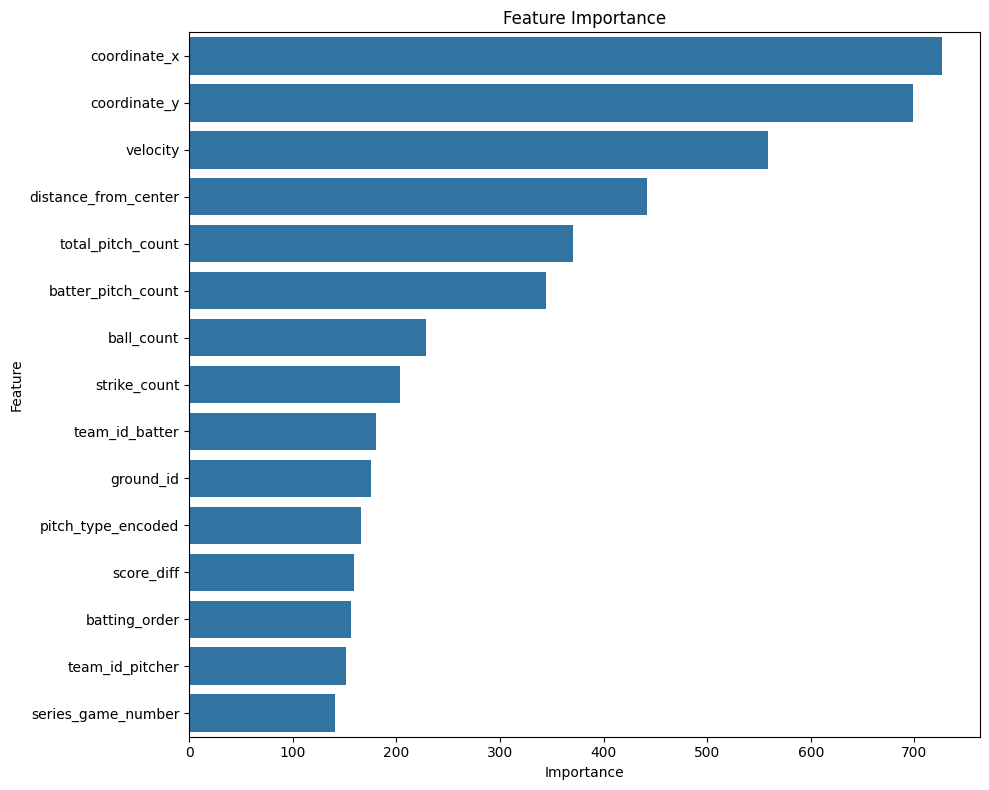

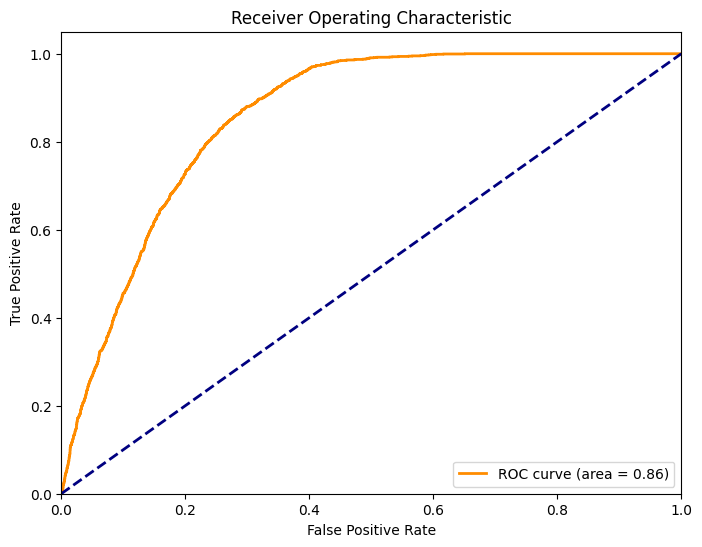

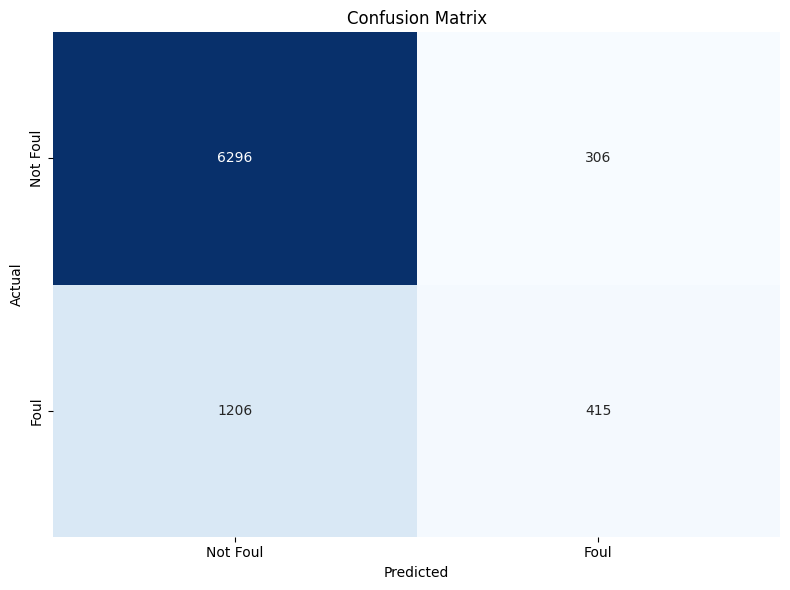

学習曲線を作成中...


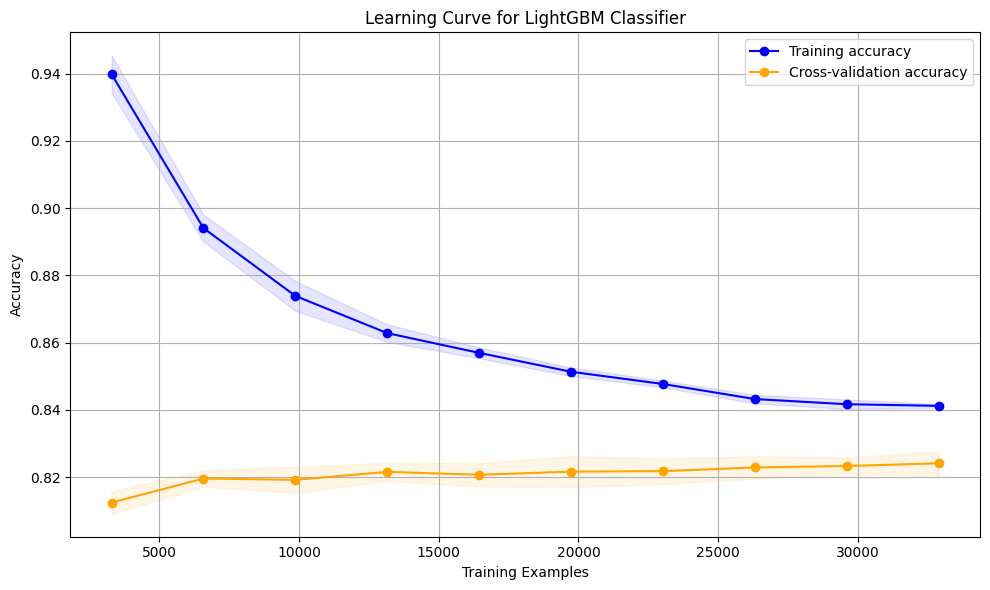

可視化結果を保存しました。
モデルを保存しています...
モデルと前処理パイプラインを保存しました。

予測の例:
入力特徴量の数: 46
入力特徴量のリスト: ['pitch_type_encoded', 'velocity', 'coordinate_x', 'coordinate_y', 'distance_from_center', 'x_from_center', 'y_from_center', 'pitch_quadrant', 'ball_count', 'strike_count', 'out_count', 'count_encoded', 'total_pitch_count', 'batter_pitch_count', 'is_first_pitch', 'is_two_strikes', 'is_three_balls', 'is_full_count', 'runner_1b_exists', 'runner_2b_exists', 'runner_3b_exists', 'runners_on_base', 'scoring_position', 'inning', 'top_bottom', 'score_diff', 'absolute_score_diff', 'is_close_game', 'is_tie_game', 'game_progress', 'total_score', 'inning_stage', 'series_game_number', 'batting_side_batter_encoded', 'pitching_side_pitcher_encoded', 'batting_order', 'pitcher_order', 'batter_number', 'team_id_batter', 'team_id_pitcher', 'ground_id', 'is_same_team', 'is_home_team_batting', 'day_of_week', 'month', 'is_weekend']
この投球がファウルになる確率: 0.41%

ファウル予測モデルの構築が完了しました！


In [92]:
if __name__ == "__main__":
    main()